In [10]:
import pandas as pd

In [11]:
df = pd.read_parquet("../data/super_processed/7_4_no2_with_traffic_and_1meteo_and_1trafic_id.parquet")

In [12]:
df = df[df['id_no2'] == '28079035']

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, f
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math

# 2. Split temporal
def split_data(df, split_date='2024-01-01'):
    df['fecha'] = pd.to_datetime(df['fecha'])
    return df[df['fecha'] < split_date], df[df['fecha'] >= split_date]

# 3. Calcular anomalías
def add_anomalies(train, test, cols):
    for col in cols:
        mean = train[col].mean()
        train[f'{col}_anom'] = train[col] - mean
        test[f'{col}_anom'] = test[col] - mean
    return train, test

# 4. Escalado
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test), scaler

def create_cyclical_features(df: pd.DataFrame) -> pd.DataFrame:
    """Crea variables cíclicas para capturar patrones temporales."""
    df = df.copy()

    # Crear variables temporales base
    df['day_of_week'] = df['fecha'].dt.dayofweek
    df['day_of_year'] = df['fecha'].dt.dayofyear
    df['month'] = df['fecha'].dt.month
    df['year'] = df['fecha'].dt.year
    df['weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['hour'] = df['fecha'].dt.hour
    df['day'] = df['fecha'].dt.day
    
    # Crear variable estacional numérica (0-3: winter, spring, summer, autumn)
    df['season'] = df['month'].apply(
        lambda x: 0 if x in [12,1,2] else 1 if x in [3,4,5] else 2 if x in [6,7,8] else 3
    )
    
    # Variables cíclicas temporales básicas
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    
    # Variables cíclicas adicionales más específicas
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
    df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)
        
    return df

In [14]:
# ---------------------------------------
# 1) Cargar / preparar df ───────────────
# ---------------------------------------
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s, f
import matplotlib.pyplot as plt
import math

df = create_cyclical_features(df)                 # función que ya tenías
train, test = split_data(df, split_date='2024-01-01')

# Anomalías
for col in ['sp', 'ssr_sum24']:
    μ = train[col].mean()
    train[f'{col}_anom'] = train[col] - μ
    test[f'{col}_anom']  = test[col]  - μ

# Variables que vamos a usar
features = [
    'intensidad_lag8',      # 0  → term 1
    't2m_ma6',              # 1  → term 2
    'd2m_ma6',              # 2  → term 3
    'sp_anom',              # 3  → term 4
    'wind_speed_ma24',      # 4  → term 5
    'wind_dir_sin_ma6',     # 5  → term 6
    'tp_sum24',             # 6  → term 7
    'ssr_sum24_anom',       # 7  → term 8
    'hour_sin',             # 8  → term 9
    'hour_cos',             # 9  → term 10
    'day_of_week_sin',      # 10 → term 11
    'day_of_week_cos',      # 11 → term 12
    'season_sin',           # 12 → term 13
    'season_cos',           # 13 → term 14
    'weekend'               # 14 → term 15
]

X_train = train[features]
X_test  = test [features]
y_train = train['no2_value']
y_test  = test ['no2_value']

# ---------------------------------------
# 2) Escalado ───────────────────────────
# ---------------------------------------
scaler      = StandardScaler().fit(X_train)
X_train_s   = scaler.transform(X_train)
X_test_s    = scaler.transform(X_test)



/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_11196/2401034385.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[f'{col}_anom'] = train[col] - μ
/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_11196/2401034385.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[f'{col}_anom']  = test[col]  - μ
/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_11196/2401034385.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_effects_joint(gam, features, scaler, n_cols=2):
    """
    Dibuja efectos parciales del GAM.
    - Pares *_sin/*_cos juntos (una única curva).
    - Resto de variables individualmente.
    - Usa el mapeo real feature→term que expone PyGAM para evitar el intercept.
    """
    # --- 1) Mapeo robusto: feature_idx -> lista de term_idx (saltamos intercept)
    feat2terms = {}
    for t_idx, term in enumerate(gam.terms):
        if getattr(term, 'isintercept', False):
            continue
        # term.feature puede ser int o iterable
        f_idx = term.feature
        if np.iterable(f_idx):
            for fi in np.atleast_1d(f_idx):
                feat2terms.setdefault(int(fi), []).append(t_idx)
        else:
            feat2terms.setdefault(int(f_idx), []).append(t_idx)

    # --- 2) Detectar pares seno/cos
    bases = {}
    for i, f in enumerate(features):
        if f.endswith('_sin'):
            bases.setdefault(f[:-4], {})['sin'] = i
        elif f.endswith('_cos'):
            bases.setdefault(f[:-4], {})['cos'] = i

    # --- 3) Lista de items a plotear, en orden de 'features'
    items, ya = [], set()
    for i, f in enumerate(features):
        base = None
        if f.endswith('_sin') or f.endswith('_cos'):
            base = f[:-4]

        if base and base in bases and base not in ya and 'sin' in bases[base] and 'cos' in bases[base]:
            items.append(('pair', base, bases[base]['sin'], bases[base]['cos']))
            ya.add(base)
        elif base and base in bases and base not in ya and (('sin' in bases[base]) ^ ('cos' in bases[base])):
            # Solo existe sin o cos -> tractamos como simple
            idx = bases[base].get('sin', bases[base].get('cos'))
            items.append(('single', features[idx], idx))
            ya.add(base)
        elif not (f.endswith('_sin') or f.endswith('_cos')):
            items.append(('single', f, i))

    # --- 4) Plot
    n_cols = int(n_cols)
    n_rows = math.ceil(len(items) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols*6, n_rows*3.3),
                             constrained_layout=True)
    axes = np.atleast_1d(axes).flatten()

    for ax, item in zip(axes, items):
        kind = item[0]

        if kind == 'single':
            _, label, feat_idx = item
            term_idx = feat2terms[feat_idx][0]  # 1º término que usa esa feature
            XX = gam.generate_X_grid(term=term_idx)

            # columna que varía en XX es precisamente la feature del término:
            varying_feature = int(gam.terms[term_idx].feature)
            x_std = XX[:, varying_feature]
            mu, sigma = scaler.mean_[varying_feature], np.sqrt(scaler.var_[varying_feature])
            x_orig = x_std * sigma + mu

            y = gam.partial_dependence(term=term_idx, X=XX)

            ax.plot(x_orig, y, lw=1.8)
            ax.set_xlabel(label)

        else:  # 'pair': *_sin + *_cos juntos
            _, base, idx_sin, idx_cos = item
            term_sin = feat2terms[idx_sin][0]
            term_cos = feat2terms[idx_cos][0]

            theta = np.linspace(0, 2*np.pi, 240)
            s, c = np.sin(theta), np.cos(theta)

            # Construimos X en espacio estandarizado (0 el resto de cols)
            Z = np.zeros((theta.size, len(features)))
            Z[:, idx_sin] = (s - scaler.mean_[idx_sin]) / np.sqrt(scaler.var_[idx_sin])
            Z[:, idx_cos] = (c - scaler.mean_[idx_cos]) / np.sqrt(scaler.var_[idx_cos])

            y = gam.partial_dependence(term=term_sin, X=Z) + gam.partial_dependence(term=term_cos, X=Z)

            # Eje X legible
            if base == 'hour':
                x = theta / (2*np.pi) * 24
                ax.set_xlabel('Hora del día'); ax.set_xlim(0, 24); ax.set_xticks([0,6,12,18,24])
            elif base == 'day_of_week':
                x = theta / (2*np.pi) * 7
                ax.set_xlabel('Día de la semana'); ax.set_xlim(0, 7)
                ax.set_xticks(range(7)); ax.set_xticklabels(['L','M','X','J','V','S','D'])
            elif base == 'season':
                x = theta / (2*np.pi) * 4
                ax.set_xlabel('Estación'); ax.set_xlim(0, 4)
                ax.set_xticks([0,1,2,3,4]); ax.set_xticklabels(['Invierno','Primavera','Verano','Otoño','Invierno'])
            else:
                x = theta; ax.set_xlabel(base)

            ax.plot(x, y, lw=1.8)
            ax.set_title(base, fontsize=10)

        ax.axhline(0, ls='--', lw=.6, c='grey')
        ax.grid(alpha=.3)

    # Ocultar axes sobrantes
    for k in range(len(items), len(axes)):
        axes[k].axis('off')

    fig.suptitle('Efectos parciales del GAM (pares seno/cos juntos)', fontsize=14)
    plt.show()



In [20]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt
from pygam import LinearGAM, s, te, f
import numpy as np

# ---- fábrica de modelos ----
def make_gam(spl=7, lam_main=50, lam_meteo=70, lam_cyc=60):
    return LinearGAM(
        s(0,  n_splines=spl, lam=lam_main) +   # intensidad_lag8
        s(1,  n_splines=spl, lam=lam_main) +   # t2m_ma6
        s(2,  n_splines=spl, lam=lam_main) +   # d2m_ma6
        s(3,  n_splines=spl, lam=lam_meteo) +  # sp_anom
        s(4,  n_splines=spl, lam=lam_meteo) +  # wind_speed_ma24
        s(5,  n_splines=6,   lam=lam_main)  +  # wind_dir_sin_ma6
        s(6,  n_splines=spl, lam=lam_meteo) +  # tp_sum24
        s(7,  n_splines=spl, lam=lam_meteo) +  # ssr_sum24_anom
        te(8, 9,   n_splines=[6,6], lam=[lam_cyc, lam_cyc]) +     # hour (sin,cos)
        te(10,11,  n_splines=[6,6], lam=[lam_cyc, lam_cyc]) +     # dow (sin,cos)
        te(12,13,  n_splines=[6,6], lam=[lam_cyc, lam_cyc]) +     # season (sin,cos)
        f(14)                                                     # weekend
    )

# ---- CV temporal con RMSE ----
def cv_rmse_params(X, y, params, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, va in tscv.split(X):
        gam = make_gam(**params)             # <— re-crear modelo
        gam.fit(X[tr], y[tr])
        pred = gam.predict(X[va])
        rmses.append(sqrt(mean_squared_error(y[va], pred)))
    return np.array(rmses)

# candidatos: “preciso” vs “suave”
candidates = [
    dict(spl=12, lam_main=30, lam_meteo=30, lam_cyc=30),  # más flexible
    dict(spl=7,  lam_main=50, lam_meteo=70, lam_cyc=60),  # más liso
]

# ejecuta CV
results = []
for p in candidates:
    rmses = cv_rmse_params(X_train_s, y_train.values, p, n_splits=5)
    results.append({'params': p, 'rmse_mean': rmses.mean(), 'rmse_std': rmses.std()})

for r in results:
    print(r)

# ---- regla 1-SE: elige el más liso dentro del umbral ----
best_idx = int(np.argmin([r['rmse_mean'] for r in results]))
best_mean = results[best_idx]['rmse_mean']
best_std  = results[best_idx]['rmse_std']
threshold = best_mean + best_std

# candidatos que cumplen 1-SE
eligible = [r for r in results if r['rmse_mean'] <= threshold]

# preferimos mayor lam (más suave); si empata, menor spl
def softness_key(r):
    p = r['params']
    return (p['lam_main'] + p['lam_meteo'] + p['lam_cyc'], -p['spl'])

chosen = max(eligible, key=softness_key)
print("\nElegido por 1-SE:", chosen)

# entrena final con todos los datos de train
gam_final = make_gam(**chosen['params']).fit(X_train_s, y_train.values)

{'params': {'spl': 12, 'lam_main': 30, 'lam_meteo': 30, 'lam_cyc': 30}, 'rmse_mean': 16.9443659528026, 'rmse_std': 2.3743462353838516}
{'params': {'spl': 7, 'lam_main': 50, 'lam_meteo': 70, 'lam_cyc': 60}, 'rmse_mean': 17.19254048483611, 'rmse_std': 2.6110933721187095}

Elegido por 1-SE: {'params': {'spl': 7, 'lam_main': 50, 'lam_meteo': 70, 'lam_cyc': 60}, 'rmse_mean': 17.19254048483611, 'rmse_std': 2.6110933721187095}


In [23]:
from math import sqrt
test_rmse = sqrt(mean_squared_error(y_test.values, gam_final.predict(X_test_s)))
print("RMSE test:", round(test_rmse, 2))

RMSE test: 15.76


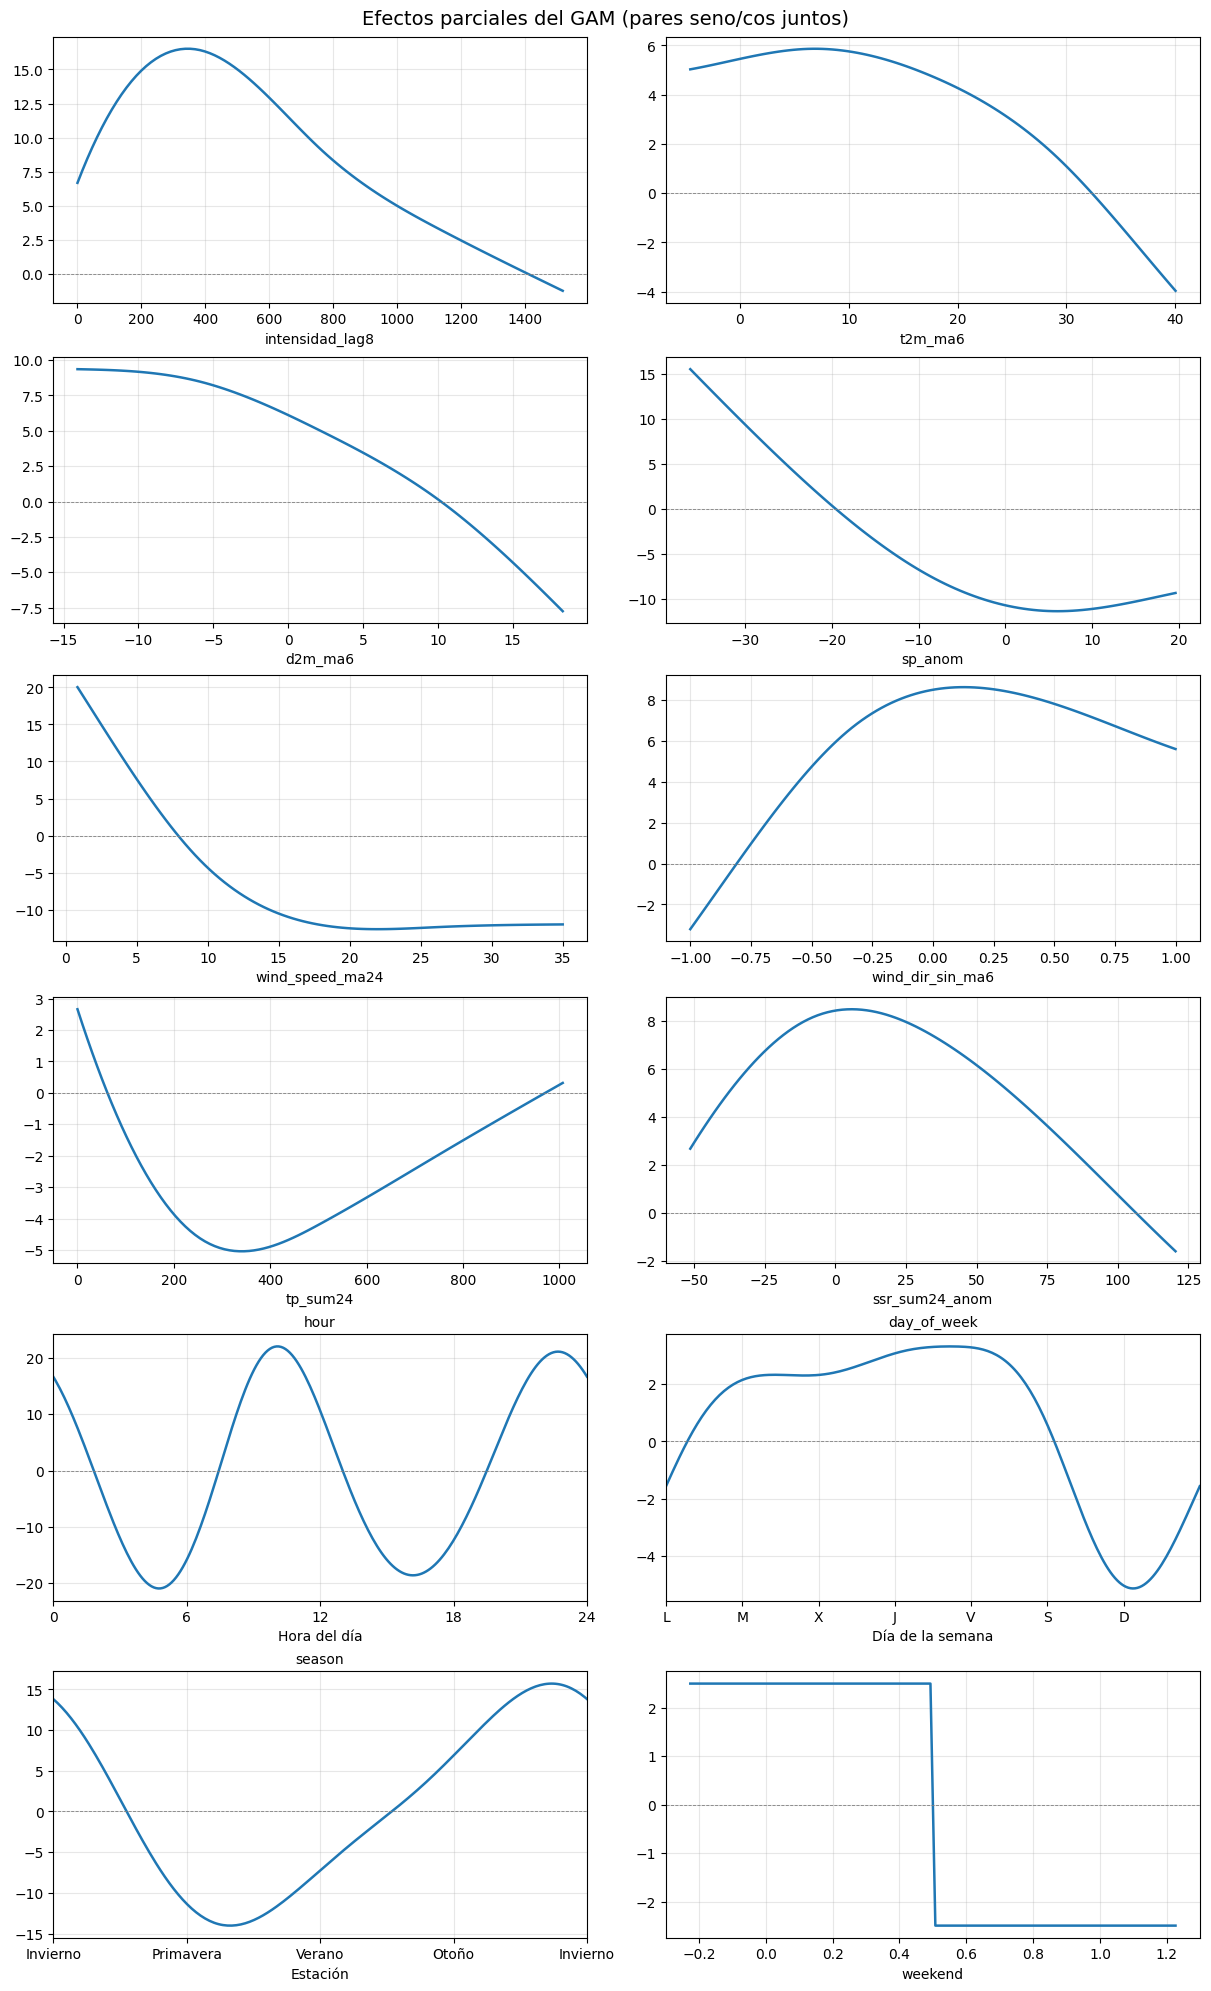

In [24]:
plot_effects_joint(gam_final, features, scaler, n_cols=2)